## setup


In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt

def runge(x: float) -> float:
    return 1 / (1 + 25 * x * x)

def neville(x: float, x_i: np.ndarray, f_i: np.ndarray) -> np.ndarray:
    n = len(x_i)
    Q = np.zeros((n,n))
    Q[:,0] = f_i
    for i in range(1,n):
        for j in range(1,i+1):
            Q[i,j] = ((x - x_i[i-j]) * Q[i,j-1] - (x - x_i[i]) * Q[i-1,j-1]) / (x_i[i] - x_i[i-j])
    return Q[n-1,:]

def tridi(alpha, beta, rhs):
    n = len(alpha)
    for i in range(1,n):
        alpha[i] -= beta[i-1] / alpha[i-1] * beta[i-1]
        rhs[i] -= beta[i-1] / alpha[i-1] * rhs[i-1]
    #x = np.zeros(n)
    #x[-1] = rhs[-1] / alpha[-1]
    rhs[-1] = rhs[-1] / alpha[-1]
    for i in range(n-2,-1,-1):
        rhs[i] = (rhs[i] - beta[i] * rhs[i+1]) / alpha[i]
    return rhs

# spline approx of runge function: 
# defining grid points

N_grid = 20
N_s = 10 
x_g = np.linspace(-1,1,N_grid + 1,endpoint=True) # grid points where we evaluate the function
x_s = np.linspace(-1,1,N_s + 1,endpoint=True) # points (per interval) where we evaluate the spline

h = x_g[range(1,N_grid+1)] - x_g[range(0,N_grid)] # grid spacing

Python Version: 3.12.9


## Question 1: 

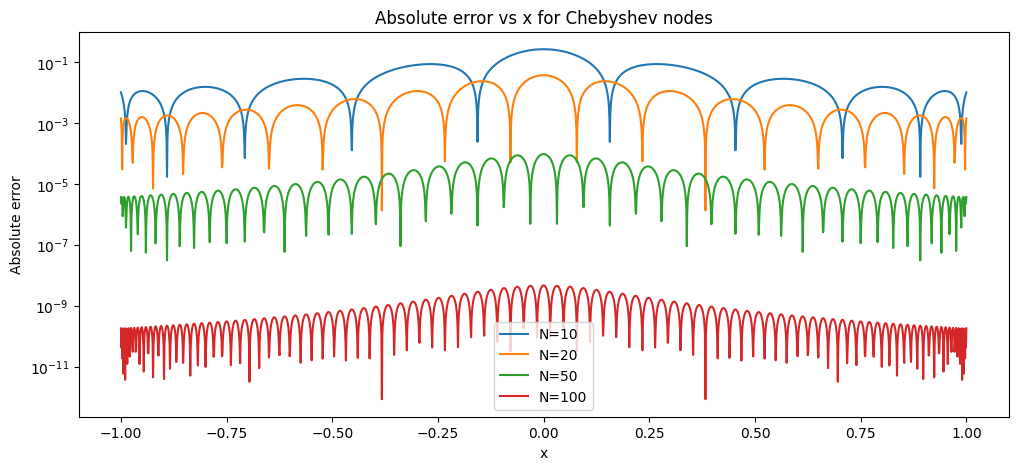

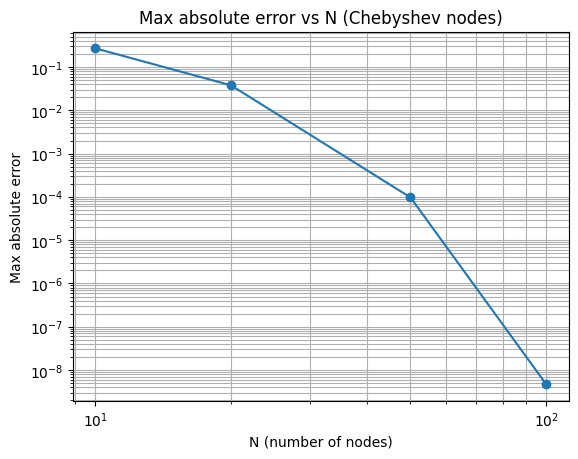

In [ ]:
c_coeff = np.zeros(N_grid + 1)
b_coeff = np.zeros(N_grid)
d_coeff = np.zeros(N_grid)

for i in range(N_grid):
    b_coeff[i] = (runge(x_g[i+1]) - runge(x_g[i]))/h[i] - h[i]*(c_coeff[i+1] + 2*c_coeff[i])/3
    d_coeff[i] = (c_coeff[i+1] - c_coeff[i])/(3*h[i])

# interpolate at cheb 0s
def chebyshev_nodes(N):
    return np.cos(np.pi * (2*np.arange(1,N+1)-1)/(2*N))

N_list = [10, 20, 50, 100]
x_dense = np.linspace(-1, 1, 2000)
f_true = runge(x_dense)
plt.figure(figsize=(12,5))
for N in N_list:
    x_nodes = chebyshev_nodes(N)
    f_nodes = runge(x_nodes)
    # Neville's method for each x_dense
    f_interp = np.array([neville(x, x_nodes, f_nodes)[-1] for x in x_dense])
    abs_err = np.abs(f_true - f_interp)
    plt.semilogy(x_dense, abs_err, label=f'N={N}')
plt.title('Absolute error vs x for Chebyshev nodes')
plt.xlabel('x')
plt.ylabel('Absolute error')
plt.legend()
plt.show()

# plot error vs N 
max_errs = []
for N in N_list:
    x_nodes = chebyshev_nodes(N)
    f_nodes = runge(x_nodes)
    f_interp = np.array([neville(x, x_nodes, f_nodes)[-1] for x in x_dense])
    abs_err = np.abs(f_true - f_interp)
    max_errs.append(np.max(abs_err))
plt.figure()
plt.loglog(N_list, max_errs, marker='o')
plt.title('Max absolute error vs N (Chebyshev nodes)')
plt.xlabel('N (number of nodes)')
plt.ylabel('Max absolute error')
plt.grid(True, which='both')
plt.show()

## Question 2:

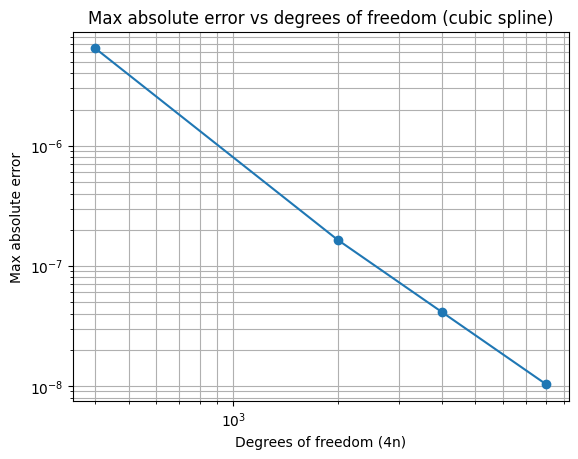

In [ ]:
def cubic_spline_coeffs(x_g, f_g):
    N = len(x_g) - 1
    h = x_g[1:] - x_g[:-1]
    alpha = np.zeros(N-1)
    beta = np.zeros(N-2)
    rhs = np.zeros(N-1)
    for i in range(N-1):
        alpha[i] = 2 * (h[i+1] + h[i])
        rhs[i] = 3 * (f_g[i+2] - f_g[i+1])/h[i+1] - 3 * (f_g[i+1] - f_g[i])/h[i]
    for i in range(N-2):
        beta[i] = h[i+1]
    c = tridi(alpha.copy(), beta.copy(), rhs.copy())
    c = np.concatenate(([0], c, [0]))
    b = np.zeros(N)
    d = np.zeros(N)
    for i in range(N):
        b[i] = (f_g[i+1] - f_g[i])/h[i] - h[i]*(c[i+1] + 2*c[i])/3
        d[i] = (c[i+1] - c[i])/(3*h[i])
    return b, c, d
def spline_eval(x_g, f_g, b, c, d, x):
    # evaluate cubic spline at x
    idx = np.searchsorted(x_g, x) - 1
    idx = np.clip(idx, 0, len(b)-1)
    dx = x - x_g[idx]
    return f_g[idx] + b[idx]*dx + c[idx]*dx**2 + d[idx]*dx**3

n_list = [100, 500, 1000, 2000]
dof_list = [4*n for n in n_list]
max_errs = []
for n in n_list:
    x_g = np.linspace(-1, 1, n+1)
    f_g = runge(x_g)
    b, c, d = cubic_spline_coeffs(x_g, f_g)
    # sample 10 points per interval
    x_dense = np.linspace(-1, 1, 10*n+1)
    f_true = runge(x_dense)
    f_spline = spline_eval(x_g, f_g, b, c, d, x_dense)
    abs_err = np.abs(f_true - f_spline)
    max_errs.append(np.max(abs_err))
plt.figure()
plt.loglog(dof_list, max_errs, marker='o')
plt.title('Max absolute error vs degrees of freedom (cubic spline)')
plt.xlabel('Degrees of freedom (4n)')
plt.ylabel('Max absolute error')
plt.grid(True, which='both')
plt.show()

## Question 3:

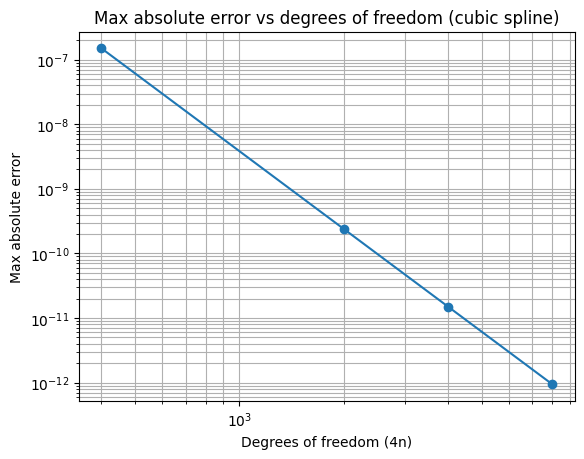

In [15]:
def new_function(x):
    return (x + 1)**6 * (x - 1)**6

n_list = [100, 500, 1000, 2000]
dof_list = [4*n for n in n_list]
max_errs = []
for n in n_list:
    x_g = np.linspace(-1, 1, n+1)
    f_g = new_function(x_g)
    b, c, d = cubic_spline_coeffs(x_g, f_g)
    # sample 10 points per interval
    x_dense = np.linspace(-1, 1, 10*n+1)
    f_true = new_function(x_dense)
    f_spline = spline_eval(x_g, f_g, b, c, d, x_dense)
    abs_err = np.abs(f_true - f_spline)
    max_errs.append(np.max(abs_err))
plt.figure()
plt.loglog(dof_list, max_errs, marker='o')
plt.title('Max absolute error vs degrees of freedom (cubic spline)')
plt.xlabel('Degrees of freedom (4n)')
plt.ylabel('Max absolute error')
plt.grid(True, which='both')
plt.show()

#### The Runge function has slower convergence due to its oscillations, while the polynomial converges faster because it is a degree 12 polynomial, so cubic splines so a pretty good job at approximating it. It is also smooth vs the Runge function's oscillations. 